# A basic analysis of population growth, rental price increases and rent restricted housing growth

## Seattle population information from worldpopulationreview.com
Definitely going to try and find a more definitive source.

YEAR  POP     Growth# Growth%

2017	724,745	17,490	2.47%

2016	707,255	21,808	3.18%

2015	685,447	15,806	2.36%

2014	669,641	15,465	2.36%

2013	654,176	18,202	2.86%

2012	635,974	13,442	2.16%

In [1]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

UsageError: Line magic function `%install_ext` not found.


In [16]:
%%time
# Bunch of unneeded imports, I'll clean up later.
# package installs, good idea to restart runtime after running this cell
# Using conda, I'll add commands here later
!pip install sodapy
!pip install geojson
# Imports
import pandas as pd
import numpy as np
import os
from cartopy import config
import cartopy.crs as ccrs
import urllib3
from io import BytesIO
import shapely
import matplotlib.pyplot as plt

# Socrata API
from sodapy import Socrata
# geojson
import geojson

client = Socrata("data.seattle.gov/", app_token="")


Wall time: 2.55 s


In [3]:
%%time
# Shapefile, doesn't include neighborhood names.
# !curl "http://data-seattlecitygis.opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.zip" > "neighborhoods.zip"
# !unzip "neighborhoods.zip"
# geojson, includes neighborhood names but can't map it easily
!curl "http://data-seattlecitygis.opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.geojson" > "neighborhoods.geojson"
# KML
# !pip install fastkml
# !curl "http://data-seattlecitygis.opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.kml" > "neighborhoods.kml"
# !ls
# with open("./neighborhoods.kml", 'rt', encoding="utf-8") as myfile:
#   doc=myfile.read().encode('utf-8')

Wall time: 1.28 s


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1002    0  1002    0     0   2822      0 --:--:-- --:--:-- --:--:--  2830
100 1782k    0 1782k    0     0  1510k      0 --:--:--  0:00:01 --:--:-- 1511k


In [4]:
%%time
import json
from shapely.geometry import shape, GeometryCollection

with open("neighborhoods.geojson") as f:
  features = json.load(f)["features"]

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
ngeo = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

Wall time: 337 ms


In [5]:
%%time
from functools import partial
import shapely.ops
import pyproj

# Suppose geometry is an instance of shapely.geometry.Geometry
tfm = partial(pyproj.transform, 
              pyproj.Proj(init="epsg:4326"), 
              pyproj.Proj(init="epsg:3031"))
reprojected = shapely.ops.transform(tfm, ngeo)

Wall time: 149 ms


In [ ]:
# # print(doc)
# import fastkml as kml
# k = kml.KML()
# k.from_string(doc)
# features = list(k.features())
# len(features)

In [6]:
%%time
low_income_housing = client.get("b6zn-zsin")
lih_df = pd.DataFrame.from_dict(low_income_housing)
lih_df.shape

Wall time: 577 ms


In [8]:
lih_df.describe()

,address,city_of_seattle,council_district,hud,name,sha,state_of_wa_or_county,units_with_income_rent_limits,wshfc,year_placed_in_service,zip_code
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,2,7,3,350,2,2,111,3,43,25
top,424 MINOR AVE N,,1,,High Point Phase I,X,,1,X,2006,98126
freq,1,639,607,975,309,700,991,647,687,313,570


In [7]:
%%time
!pip install googlemaps
import json
import googlemaps as gm
with open('gapikey.json') as json_file:
    apikey = json.load(json_file)['apikey']
gmaps = gm.Client(key=apikey)

Wall time: 1.24 s


In [8]:
%%time
address = lih_df.loc[0]
# print(address['address'] + ' Seattle, WA ' + address['zip_code'])
geocode = gmaps.geocode(str(address['address'] + " Seattle, WA " + address['zip_code']))[0]
geocode['geometry']['location']

Wall time: 592 ms


In [9]:
%%time
def get_geocode(datarow):
    geocode = gmaps.geocode(str(datarow['address'] + " Seattle, WA " + datarow['zip_code']))
    return geocode[0]['geometry']['location']
def apply_lat_lon_columns(df):
#     new_df = df.copy()
    latlngs = []
    for index, row in df.iterrows():
        latlng = get_geocode(row)
        latlngs.append(latlng)
    return latlngs

latlngs = apply_lat_lon_columns(lih_df)
# lih_df['lat'] = lih_df['address'].apply(lambda x)

In [50]:
print(lih_df_new)

[{'lat': 47.615384, 'lng': -122.3168652}, {'lat': 47.7286231, 'lng': -122.3076156}, {'lat': 47.7297958, 'lng': -122.3338612}, {'lat': 47.6707472, 'lng': -122.3795152}, {'lat': 47.6179606, 'lng': -122.3022248}, {'lat': 47.6182239, 'lng': -122.3295729}, {'lat': 47.618016, 'lng': -122.3165818}, {'lat': 47.6132475, 'lng': -122.2996395}, {'lat': 47.6155808, 'lng': -122.3271119}, {'lat': 47.5682418, 'lng': -122.2964603}, {'lat': 47.6223506, 'lng': -122.3175076}, {'lat': 47.663013, 'lng': -122.320387}, {'lat': 47.5602534, 'lng': -122.3866063}, {'lat': 47.6643009, 'lng': -122.3057391}, {'lat': 47.7080656, 'lng': -122.3226005}, {'lat': 47.6646228, 'lng': -122.3171692}, {'lat': 47.70837119999999, 'lng': -122.3215923}, {'lat': 47.6258042, 'lng': -122.3441011}, {'lat': 47.6903765, 'lng': -122.3598463}, {'lat': 47.69321129999999, 'lng': -122.3543884}, {'lat': 47.6137562, 'lng': -122.332412}, {'lat': 47.5994749, 'lng': -122.3048642}, {'lat': 47.5998894, 'lng': -122.3285612}, {'lat': 47.5806029, 'lng

In [12]:
%%time
# for i in range(len(lih_df)):
#     lih_df.loc[i]['lat'] = lih_df_new[i]['lat']
#     lih_df.loc[i]['lng'] = lih_df_new[i]['lng']
# lih_df.head()
lats = []
lngs = []
for i in range(len(latlngs)):
    lats.append(latlngs[i]['lat'])
    lngs.append(latlngs[i]['lng'])
print(lats)

[47.615384, 47.7286231, 47.7297958, 47.6707472, 47.6179606, 47.6182239, 47.618016, 47.6132475, 47.6155808, 47.5682418, 47.6223506, 47.663013, 47.5602534, 47.6643009, 47.7080656, 47.6646228, 47.70837119999999, 47.6258042, 47.6903765, 47.69321129999999, 47.6137562, 47.5994749, 47.5998894, 47.5806029, 47.7124721, 47.7125296, 47.5614597, 47.64996410000001, 47.54372129999999, 47.6041782, 47.5973061, 47.63658119999999, 47.5612376, 47.6210798, 47.6179465, 47.5592356, 47.6150367, 47.6199062, 47.5967008, 47.60191469999999, 47.6173468, 47.7310258, 47.521252, 47.5634212, 47.7055763, 47.6690085, 47.5682372, 47.5680317, 47.6213612, 47.62329980000001, 47.6139473, 47.6175343, 47.6696553, 47.6861212, 47.6708195, 47.6755124, 47.6060435, 47.6229289, 47.5205296, 47.6172992, 47.6176936, 47.5888841, 47.5886133, 47.5882132, 47.6128285, 47.6166121, 47.6136836, 47.6134285, 47.704136, 47.624274, 47.6142778, 47.5382456, 47.723733, 47.723933, 47.55679600000001, 47.6657869, 47.7006215, 47.6532043, 47.619481, 47.6

In [13]:
lih_df['lat'] = lats
lih_df['lng'] = lngs
lih_df.head()

,address,city_of_seattle,council_district,hud,name,sha,state_of_wa_or_county,units_with_income_rent_limits,wshfc,year_placed_in_service,zip_code,lat,lng
0,1606 12TH AVE,X,3,,12th Avenue Arts,,,86,X,2014,98122,47.615384,-122.316865
1,13701 20TH AVE NE,,5,,13701 20th Ave NE,,X,4,,2009,98125,47.728623,-122.307616
2,13736 MERIDIAN AVE N,X,5,,13736 Meridian Ave N,,,4,,2003,98133,47.729796,-122.333861
3,1715 NW 58TH ST,X,6,,1715 Apartments,,,9,,2015,98107,47.670747,-122.379515
4,1806 23RD AVE,X,3,,1806 23rd Ave,,,13,,2014,98122,47.617961,-122.302225


In [14]:
lih_df['units_with_income_rent_limits'] = pd.to_numeric(lih_df['units_with_income_rent_limits'])
lih_df['council_district'] = pd.to_numeric(lih_df['council_district'])
lih_df['year_placed_in_service'] = pd.to_numeric(lih_df['year_placed_in_service'])

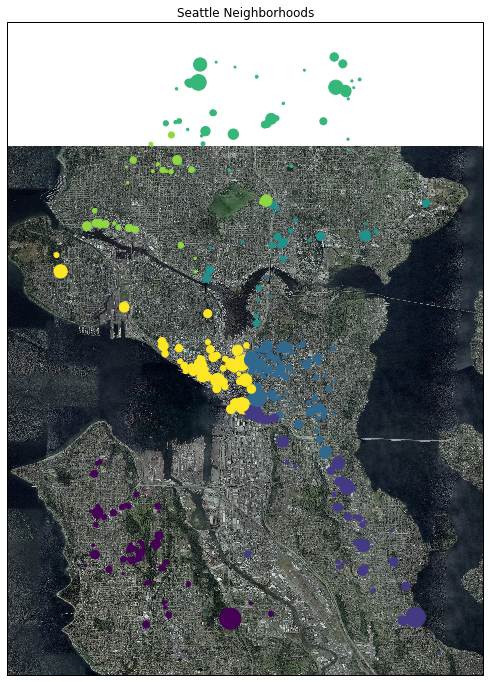

In [60]:
import os
from cartopy import config
import cartopy.crs as ccrs
import urllib3
from io import BytesIO

url = 'http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=380463.34254564694,56823.4715542678,394429.04176870215,78792.15755500927&bboxSR=32148&imageSR=32148&size=2000,3146&dpi=96&format=png32&transparent=true&f=image'

img = plt.imread(url)
# if f.mode == 'r':
#     img = f.read()
img_extent = (-122.42, -122.24, 47.5, 47.7)

# Draw map of Seattle 47.515961, -122.424454 47°44'04.6"N 122°14'25.8"W

fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
plt.scatter(lih_df['lng'], lih_df['lat'],
            s=lih_df['units_with_income_rent_limits'], c=lih_df['council_district'])
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
# m = Basemap(llcrnrlon=-122.42,llcrnrlat=47.5,urcrnrlon=-122.24,urcrnrlat=47.7, epsg=32148)
plt.title('Seattle Neighborhoods')
# # map.bluemarble(scale=2)
# map.etopo(scale=1, alpha=1)
# m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000, verbose=True)
# fig.get_axes()[0].spines['top'].set_visible(True)
# fig.get_axes()[0].spines['right'].set_visible(True)
# fig.get_axes()[0].add_collection(reprojected)
# ngeo
# m.readshapefile('./City_Clerk_Neighborhoods', 'neighborhoods', linewidth=2)
# map.drawcoastlines()
# map.drawrivers()
# map.drawcounties()
# map.fillcontinents(color='red',lake_color='aqua')

plt.show()

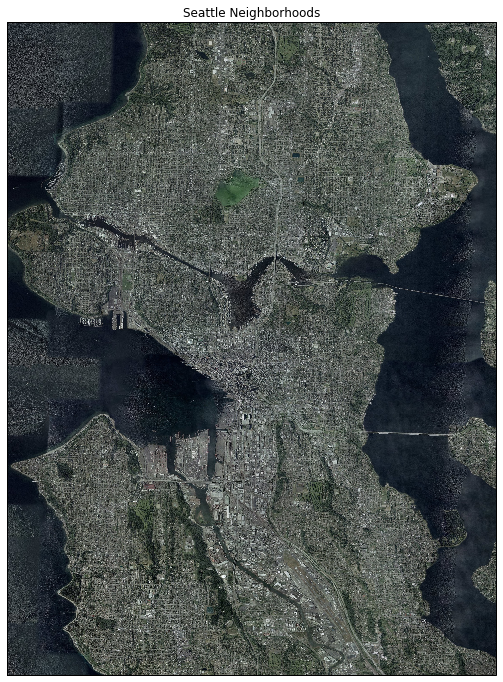

In [17]:
%%time
# Expects a function that renders other features on top of the map of Seattle
def render_seattle_map(map_features=lambda ax:0):
    url = 'http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=380463.34254564694,56823.4715542678,394510.32706265344,83238.65949753723&bboxSR=32148&imageSR=32148&size=2000,3760&dpi=96&format=png32&transparent=true&f=image'
    
    img = plt.imread(url)
    
    img_extent = (-122.42, -122.24, 47.5, 47.74)
    # Draw map of Seattle 47.515961, -122.424454 47°44'04.6"N 122°14'25.8"W
    fig = plt.figure(figsize=(16,12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
    map_features(ax)
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    plt.title('Seattle Neighborhoods')

    plt.show()
render_seattle_map()

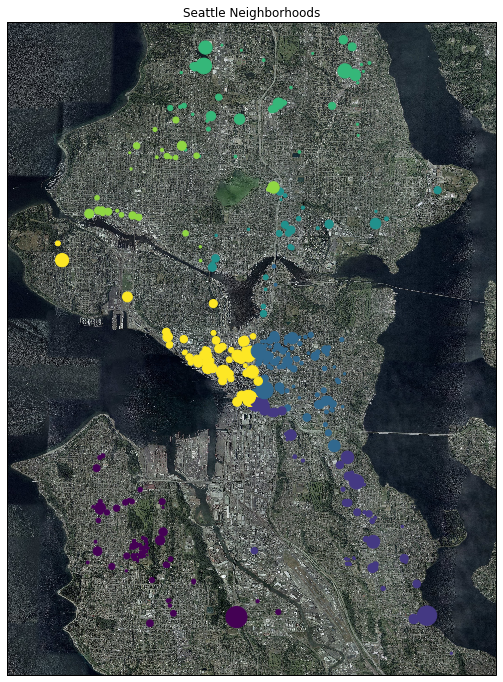

Wall time: 30.6 s


In [18]:
%%time
render_seattle_map(lambda ax: plt.scatter(lih_df['lng'], lih_df['lat'],
            s=lih_df['units_with_income_rent_limits'], c=lih_df['council_district']))

In [81]:
print(lih_df[lih_df['council_district'] == 1]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 2]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 3]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 4]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 5]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 6]['units_with_income_rent_limits'].sum())
print(lih_df[lih_df['council_district'] == 7]['units_with_income_rent_limits'].sum())


2174
3071
3094
858
2034
898
4277


In [23]:
print(lih_df[(lih_df['council_district'] == 1)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 2)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 3)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 4)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 5)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 6)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())
print(lih_df[(lih_df['council_district'] == 7)&(lih_df['year_placed_in_service'] <= 2012)]['units_with_income_rent_limits'].sum())


1901
1969
2482
493
1640
648
3873


In [87]:
print(lih_df['units_with_income_rent_limits'].sum())
lih_df[(lih_df['year_placed_in_service'] < 2012)]['units_with_income_rent_limits'].sum()

16406


12324

In [29]:
seattle_pop = pd.DataFrame([[2012,2013,2014,2015,2016,2017], [635974,654176,669641,685447,707255,724745]])
seattle_pop = seattle_pop.T
seattle_pop.columns = ['year', 'population']
seattle_pop = seattle_pop.set_index('year')
seattle_pop

,population
year,
2012,635974
2013,654176
2014,669641
2015,685447
2016,707255
2017,724745


In [32]:
print("2017 population per low income unit:")
print(seattle_pop.loc[2017]['population']/lih_df[lih_df['year_placed_in_service'] <= 2017]['units_with_income_rent_limits'].sum())
print("2012 population per low income unit:")
print(seattle_pop.loc[2012]['population']/lih_df[lih_df['year_placed_in_service'] <= 2012]['units_with_income_rent_limits'].sum())


2017 population per low income unit:
44.17560648543216
2012 population per low income unit:
48.898508380747344


In [46]:
low_income_units = []
for year in range(2012,2018):
    low_income_units.append(lih_df[lih_df['year_placed_in_service'] <= year]['units_with_income_rent_limits'].sum())
seattle_pop['low_income_units'] = low_income_units
seattle_pop['low_income_ratio'] = seattle_pop['population']/seattle_pop['low_income_units']
seattle_pop

,population,low_income_units,low_income_ratio
year,,,
2012,635974,13006,48.898508
2013,654176,13908,47.035951
2014,669641,14610,45.834428
2015,685447,15624,43.871416
2016,707255,16366,43.214897
2017,724745,16406,44.175606


In [60]:
print(seattle_pop['population'].pct_change())
print(seattle_pop['low_income_units'].pct_change())
print(seattle_pop['low_income_ratio'].pct_change())

(6,)
year
2012         NaN
2013    0.069353
2014    0.050475
2015    0.069405
2016    0.047491
2017    0.002444
Name: low_income_units, dtype: float64
year
2012         NaN
2013   -0.038090
2014   -0.025545
2015   -0.042828
2016   -0.014965
2017    0.022231
Name: low_income_ratio, dtype: float64


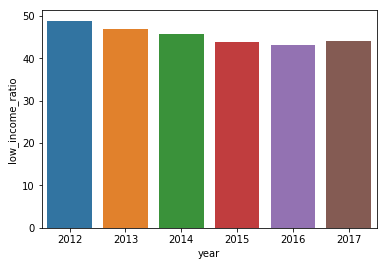

In [57]:
import seaborn as sns
sns.barplot(x=seattle_pop.index, y="low_income_ratio", data=seattle_pop)
plt.show()
# seattle_pop.plot()


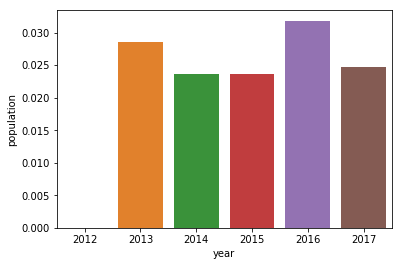

In [63]:
sns.barplot(x= seattle_pop.index, y=seattle_pop['population'].pct_change())
plt.show()

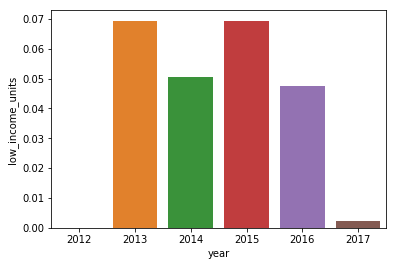

In [64]:
sns.barplot(x= seattle_pop.index, y=seattle_pop['low_income_units'].pct_change())
plt.show()

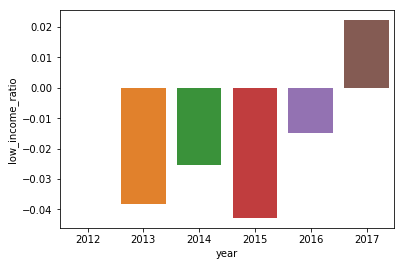

In [65]:
sns.barplot(x= seattle_pop.index, y=seattle_pop['low_income_ratio'].pct_change())
plt.show()

In [58]:
lih_df.describe()

,council_district,units_with_income_rent_limits,year_placed_in_service,lat,lng
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.116000,16.406000,2004.826000,47.572404,-122.350350
std,1.812686,37.876666,8.007862,0.047856,0.030803
min,1.000000,1.000000,1967.000000,47.507937,-122.401342
25%,1.000000,1.000000,2003.000000,47.543941,-122.372012
50%,1.000000,1.000000,2006.000000,47.547421,-122.369397
75%,3.000000,15.000000,2009.000000,47.599810,-122.324877
max,7.000000,443.000000,2017.000000,47.733627,-122.256607


In [ ]:
# Poverty rate Seattle 13.6% 2012
# https://www.washington.edu/news/2014/09/18/poverty-income-inequality-increase-in-washington-state/
# Poverty rate Seattle 12.5% 2017
# US Census: https://www.census.gov/quickfacts/geo/chart/seattlecitywashington/IPE120217

In [33]:
# Quickly save the dataset to avoid having to spend 10 minutes doing synchronous requests to the google maps api
lih_df.to_csv('low_income_seattle.csv')